# Facial Keypoint Detection

* [Detect Faces and Eyes Using a Haar Cascade Classifier](#part1)
* [Automatically Hide the Identity of an Individual](#part2)
* [CNN to Detect Facial Keypoints](#part3)
* [Facial Keypoints Detection Pipeline](#part4)
* [Add a Filter Using Facial Keypoints](#part5)

In [1]:
# Import required libraries for this section

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import cv2                     # OpenCV library for computer vision
from PIL import Image
import time 

---
<a id='part1'></a>

## Detect Faces and Eyes Using a Haar Cascade Classifier

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades). One of these detectors are downloaded and stored in the `detector_architectures` directory.

### Example

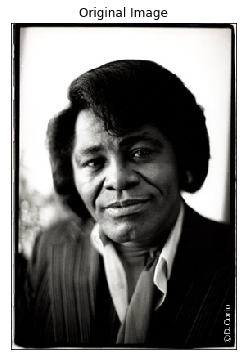

In [2]:
# Load in color image for face detection
image = cv2.imread('images/james.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the RGB image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

Notice that even though the image is a black and white image, we have read it in as a color image and so it will still need to be converted to grayscale in order to perform the most accurate face detection.

Number of faces detected: 1


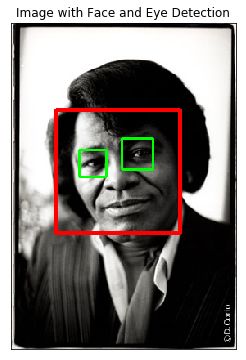

In [4]:
# Convert the RGB  image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray, 1.25, 6)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the original image to plot rectangle detections
image_with_detections = np.copy(image)   

# Loop over the detections and draw their corresponding face detection boxes
for (x,y,w,h) in faces:
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h),(255,0,0), 3)
    

## Add eye detection, using haarcascade_eye.xml, to the current face detector algorithm
## Loop over the eye detections and draw their corresponding boxes in green on image_with_detections
eye_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_eye.xml')
for (x0,y0,w0,h0) in faces:
    eyes = eye_cascade.detectMultiScale(gray[y0:y0+h0,x0:x0+w0], 1.1, 6)
    for (x1,y1,w1,h1) in eyes:
        cv2.rectangle(image_with_detections, (x0+x1,y0+y1), (x0+x1+w1,y0+y1+h1),(0,255,0), 2)
        
# Plot the image with both faces and eyes detected
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Image with Face and Eye Detection')
ax1.imshow(image_with_detections)

---
<a id='part2'></a>

## Automatically Hide the Identity of an Individual

We can use the face detection pipeline and ```filter2D``` to blur the identity of the person in images.

### Example

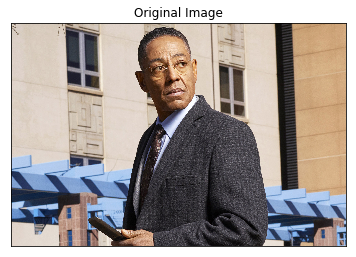

In [5]:
# Load in the image
image = cv2.imread('images/gus.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Original Image')
ax1.imshow(image)

Number of faces detected: 1


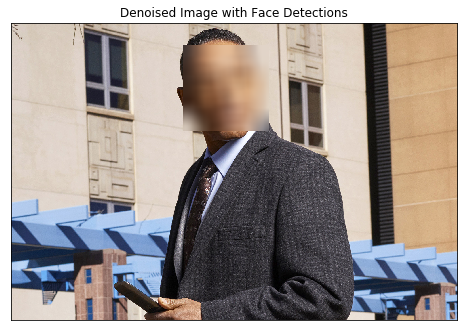

In [6]:
## Implement face detection
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray, 2, 4)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# # Make a copy of the orginal image to draw face detections on
image_with_blurring = np.copy(image)

## Blur the bounding box around each detected face using an averaging filter and display the result
kernel = np.ones((100,100), np.float32)/1e4
for (x,y,w,h) in faces:
    image_with_blurring[y:y+h,x:x+w] = cv2.filter2D(image[y:y+h,x:x+w], -1, kernel)


# Display the image with the detections
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Denoised Image with Face Detections')
ax1.imshow(image_with_blurring)

---
<a id='part3'></a>

## CNN to Detect Facial Keypoints

Facial keypoints (also called facial landmarks) are the small blue-green dots shown on each of the faces in the image above - there are 15 keypoints marked in each image.  They mark important areas of the face - the eyes, corners of the mouth, the nose, etc.

<img src="images/keypoints_test_results.png" width=400 height=300/>

We train a CNN to detect facial keypoints in a small dataset of cropped images of human faces.

The training dataset is from [Kaggle](https://www.kaggle.com/c/facial-keypoints-detection/data). It contains several thousand $96 \times 96$ grayscale images of cropped human faces, along with each face's 15 corresponding facial keypoints that have been placed by hand, and recorded in $(x, y)$ coordinates.

In [7]:
from utils import *

# Load training set
X_train, y_train = load_data()
print("X_train.shape == {}".format(X_train.shape))
print("y_train.shape == {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))

# Load testing set
X_test, _ = load_data(test=True)
print("X_test.shape == {}".format(X_test.shape))

Using TensorFlow backend.


X_train.shape == (2140, 96, 96, 1)
y_train.shape == (2140, 30); y_train.min == -0.920; y_train.max == 0.996
X_test.shape == (1783, 96, 96, 1)


For each training image, there are two landmarks per eyebrow (**four** total), three per eye (**six** total), **four** for the mouth, and **one** for the tip of the nose.  

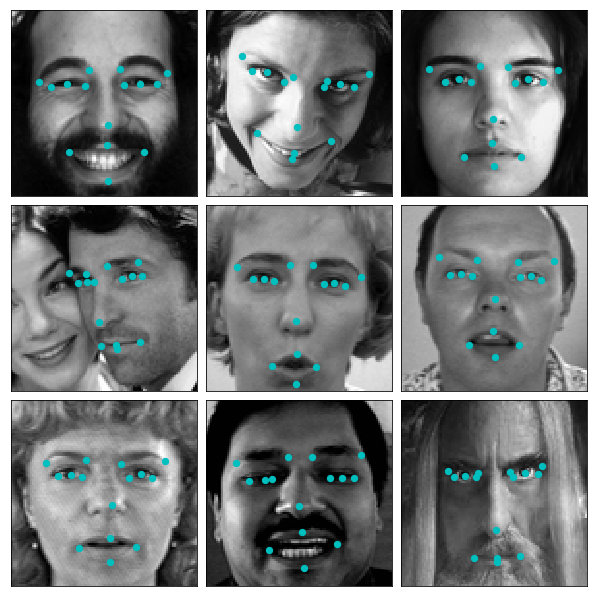

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_train[i], y_train[i], ax)

### Compile and train CNN model

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense


## CNN architecture
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(96,96,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(30))

In [18]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

## TODO: Compile the model
model.compile(optimizer='Adam', loss='mse')

## TODO: Train the model
hist = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2)

## TODO: Save the model as model.h5
model.save('my_model.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/10
1712/1712 [==============================] - 20s - loss: 0.0116 - val_loss: 0.0040
Epoch 2/10
1712/1712 [==============================] - 21s - loss: 0.0033 - val_loss: 0.0029
Epoch 3/10
1712/1712 [==============================] - 21s - loss: 0.0021 - val_loss: 0.0020
Epoch 4/10
1712/1712 [==============================] - 21s - loss: 0.0016 - val_loss: 0.0017
Epoch 5/10
1712/1712 [==============================] - 21s - loss: 0.0014 - val_loss: 0.0014
Epoch 6/10
1712/1712 [==============================] - 22s - loss: 0.0011 - val_loss: 0.0013
Epoch 7/10
1712/1712 [==============================] - 21s - loss: 9.4533e-04 - val_loss: 0.0013
Epoch 8/10
1712/1712 [==============================] - 21s - loss: 8.3748e-04 - val_loss: 0.0012
Epoch 9/10
1712/1712 [==============================] - 22s - loss: 6.8418e-04 - val_loss: 0.0013
Epoch 10/10
1712/1712 [==============================] - 22s - loss: 5.9977e-04 - val_loss: 0.0

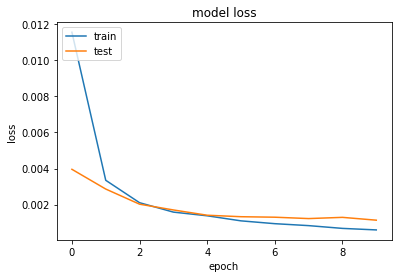

In [19]:
## Visualize the training and validation loss of your neural network

fig = plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

__Question 3:__  Do you notice any evidence of overfitting or underfitting in the above plot?  If so, what steps have you taken to improve your model?  Note that slight overfitting or underfitting will not hurt your chances of a successful submission, as long as you have attempted some solutions towards improving your model (such as _regularization, dropout, increased/decreased number of layers, etc_).

__Answer:__

### Visualize Test Predictions

In [12]:
model = load_model('my_model.h5')

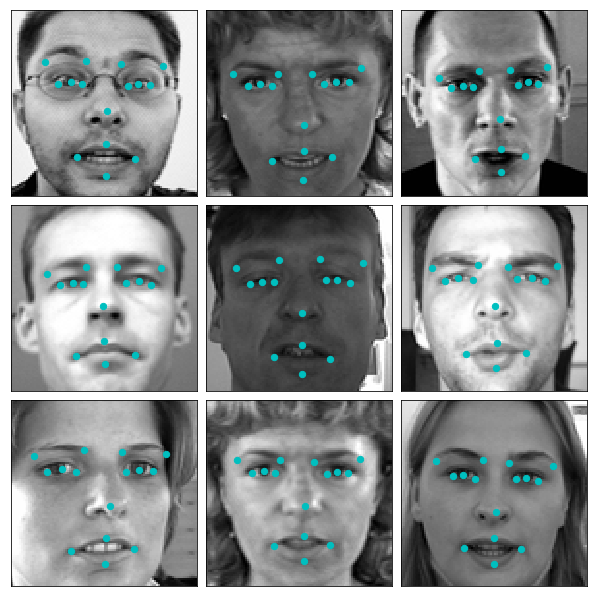

In [13]:
y_test = model.predict(X_test)
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_test[i], y_test[i], ax)

---
<a id='part4'></a>

## Facial Keypoints Detection Pipeline

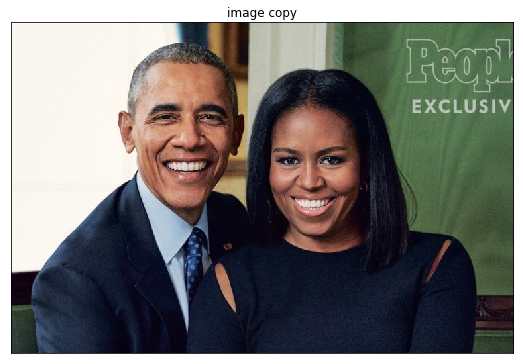

In [14]:
# Load in color image for face detection
image = cv2.imread('images/obamas4.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot our image
fig = plt.figure(figsize = (9,9))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('image copy')
ax1.imshow(image)

Number of faces detected: 2


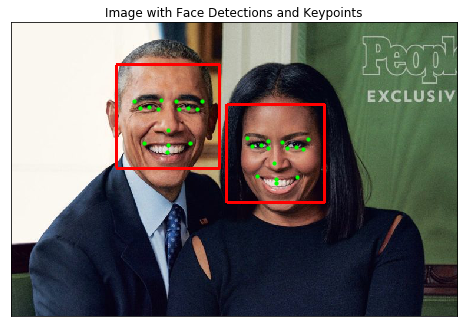

In [15]:
# Convert the RGB  image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray, 1.25, 4)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(image)

# Get the bounding box for each detected face
xlandmarks = []
ylandmarks = []
for (x,y,w,h) in faces:
    # Find keypoints
    resized_image = cv2.resize(gray[y:y+h,x:x+w], (96,96)) / 255
    lmarks = model.predict(resized_image.reshape(1,96,96,1))[0]  
    xlandmarks.extend(lmarks[0::2]*w/2+w/2+x)
    ylandmarks.extend(lmarks[1::2]*h/2+h/2+y)
    # Add a red bounding box to the detections image    
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)

# Display the image with the detections
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Image with Face Detections and Keypoints')
ax1.imshow(image_with_detections)
ax1.scatter(xlandmarks, ylandmarks, marker='o', c=(0,1,0), s=10)

---
<a id='part5'></a>

### Add a Filter Using Facial Keypoints

Using facial keypoint detector pipeline, one can add filters to a person's face automatically. We shall add sunglasses automatically to each individual's face in an image.

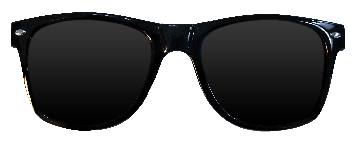

In [16]:
sunglasses = cv2.imread("images/sunglasses_4.png", cv2.IMREAD_UNCHANGED)

# Plot the image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(sunglasses)
ax1.axis('off');

In [8]:
# Print out the shape of the sunglasses image
print ('The sunglasses image has shape: ' + str(np.shape(sunglasses)))

The sunglasses image has shape: (1123, 3064, 4)


The first 3 channels are the RGB channels, and the 4th channel represents the transparency level of each pixel in the image: the lower the value, the more transparent the pixel will become.

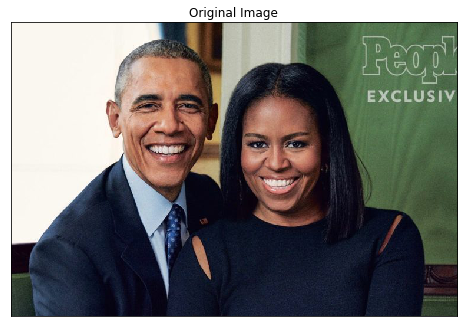

In [37]:
# Load in color image for face detection
image = cv2.imread('images/obamas4.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Original Image')
ax1.imshow(image)

Number of faces detected: 2


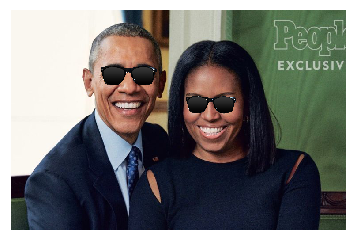

In [17]:
# Convert the RGB  image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray, 1.25, 4)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
overlay = np.copy(image)
output = np.copy(image)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Find keypoints
    resized_image = cv2.resize(gray[y:y+h,x:x+w], (96,96)) / 255
    lmarks = model.predict(resized_image.reshape(1,96,96,1))[0]  
    xlandmarks = lmarks[0::2]*w/2+w/2+x
    ylandmarks = lmarks[1::2]*h/2+h/2+y
    
    # Resize sunglasses image to fit face
    u1, u2 = xlandmarks[9], xlandmarks[7]
    v1, v2 = np.mean(ylandmarks[6:9]), ylandmarks[10]
    usize = int(1.1*(u2-u1))
    vsize = int(1.1*(u2-u1)*sunglasses.shape[0]/sunglasses.shape[1])
    sunglasses_resized = cv2.resize(sunglasses, (usize, vsize))

    # Overlay sunglasses image to the image
    u0 = (u1+u2)/2
    x1 = int(u0-sunglasses_resized.shape[1]/2)
    x2 = int(u0+sunglasses_resized.shape[1]/2)
    y1 = int(v1-0.1*(v2-v1))
    y2 = y1+sunglasses_resized.shape[0]
    alpha_s = sunglasses_resized[:,:,3] / 255.0
    alpha_l = 1.0 - alpha_s
    for c in range(0, 3):
        output[y1:y2,x1:x2,c] = (alpha_s * sunglasses_resized[:,:,c] +
                                 alpha_l * output[y1:y2,x1:x2,c])


# Display the image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(output)
ax1.axis('off');